Categorical columns to encode: Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')
Class distribution before SMOTE: label
1    31732
0    25900
Name: count, dtype: int64
Class distribution after SMOTE: label
0    31732
1    31732
Name: count, dtype: int64
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     11100
           1       0.97      0.96      0.97     13600

    accuracy                           0.96     24700
   macro avg       0.96      0.96      0.96     24700
weighted avg       0.96      0.96      0.96     24700

Confusion Matrix:
[[10730   370]
 [  537 13063]]


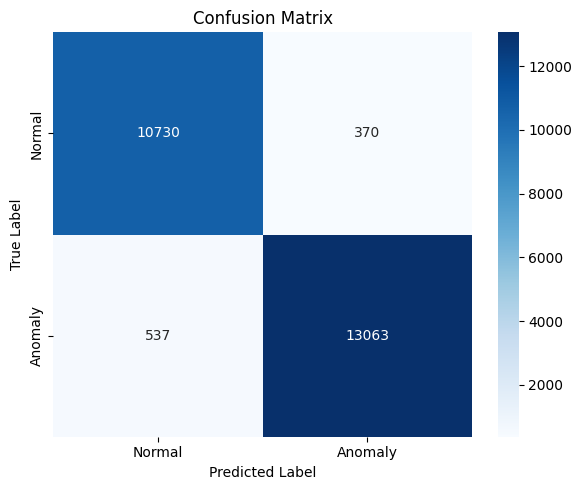

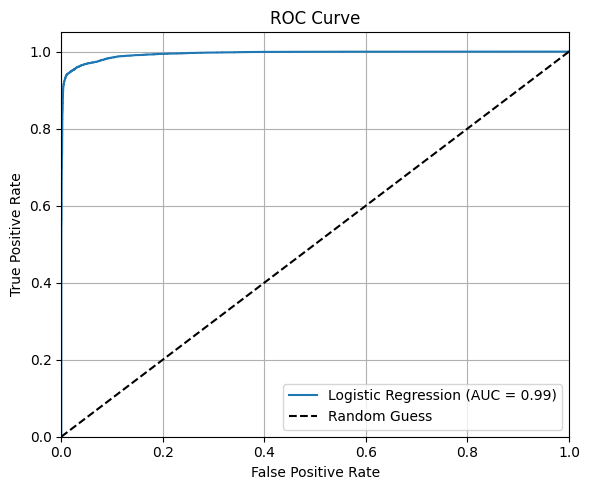

ROC AUC Score: 0.9940559883412824


In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data_path = '/Users/sarahsteadham/Downloads/CyberProject/UNSW_testing-set.csv'
df = pd.read_csv(data_path)

# Prepare features and labels
X = df.drop(columns=['label'])
y = df['label']

# Encode categorical features
categorical_columns = X.select_dtypes(include=['object']).columns
print("Categorical columns to encode:", categorical_columns)
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Scale the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Debug info
print("Class distribution before SMOTE:", y_train.value_counts())
print("Class distribution after SMOTE:", pd.Series(y_train_smote).value_counts())

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_smote, y_train_smote)

# Save model and preprocessors
joblib.dump(model, 'network_anomaly_model_unseen.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(imputer, 'imputer.pkl')

# Predictions and evaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# ---- Visual 1: Confusion Matrix Heatmap ----
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# ---- Visual 2: ROC Curve ----
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()

# Print AUC
print("ROC AUC Score:", roc_auc)

